In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [72]:
#np.random.seed(123)

# Hidden Markov Model Assignment

The robot can move on the cells with light background, but cannot go over the obstacles, which have the dark blue background.


### Maze definition

Here I define the robot’s environment as a 2D NumPy array.
- Each **1** represents a feasible cell where the robot can be.
- Each **0** represents an obstacle where the robot cannot move which can be called blocks or Unreachable.

This maze will be the basis for defining the states and transitions of the HMM.


In [73]:
# Boolean representation of a random maze. True=feasible, False=obstacle.
# Use the maze corresponding to your group!
maze = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0],
    [0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1],
    [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0],
])

### Visualizing the maze

The function `plot_maze` helps us in rawing of the  maze as a grid:
- Feasible cells are light blue.
- Obstacles or Blocks are dark blue.
- Each cell gets a unique index, which we use later to map positions to HMM states.
- Optionally, a given trajectory `Z` can be highlighted in red.

This visualization helps to understand how states relate to physical positions.



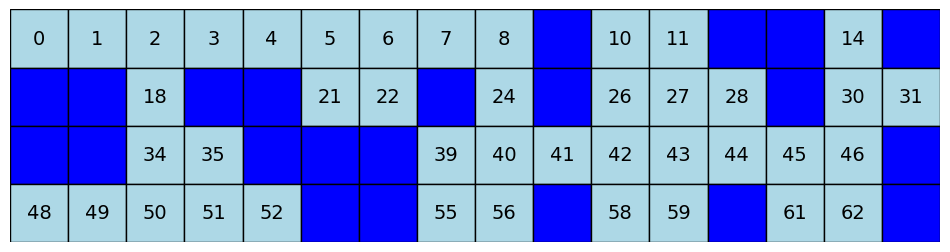

In [74]:
def plot_maze(ax, maze, skip_walls=True, Z=None):
    cell_idx = 0
    rows, cols = maze.shape
    for r in range(rows):
        for c in range(cols):
            color = 'lightblue' if maze[r, c] == 1 else 'blue'

            if Z is not None and (r * cols + c) in Z:
                color = 'red'

            ax.add_patch(patches.Rectangle((c, rows - 1 - r), 1, 1, edgecolor='black', facecolor=color))
            if maze[r, c] == 1 or not skip_walls:
                ax.text(c + 0.5, rows - 1 - r + 0.5, str(cell_idx), color='black', ha='center', va='center',
                        fontsize=14)
            cell_idx += 1

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)

    ax.set_aspect('equal')
    ax.axis('off')


fig, ax = plt.subplots(figsize=(12, 9))

plot_maze(ax, maze)

### Defintion of the states
the states are a list of all the posssibile cells (rows, columns)which are flessibile of thr maze matrix / grid , which the robot can naigate through.

In [75]:
# Suggested names for possible states
rows, cols = maze.shape
states = [(r, c) for r in range(rows) for c in range(cols) if maze[r, c]]


### Observation vocabulary
 Suggested names for the possible observations.The robot’s sensor reads which directions (N, S, E, W) are feasible from the current cell.
There are \(2^4 = 16\) possible combinations, so we build a **vocabulary** of 16 observation symbols:

- Each symbol corresponds to a 4-bit pattern (N, S, E, W).
- For example, (NE) means “North and East are free; South and West are blocked”.

In [76]:
# Suggested names for the possible observations. If can be seen as a binary digit from 0 to 15, where the least significant bit indicates West.
# This may be usefule to code the emission matrix
letters = ['N', 'S', 'E', 'W']
vocabulary = []
for i in range(2 ** len(letters)):  # observations can be indexed with numbers 0 to 15
    binary = format(i, '04b')  # 4-bit format interpreted as possibility to move N,S,E,W
    combination = ''.join([letters[j] for j in range(4) if binary[j] == '1'])
    combination = '(' + combination + ')'
    vocabulary.append(combination)

In [77]:
vocabulary

['()',
 '(W)',
 '(E)',
 '(EW)',
 '(S)',
 '(SW)',
 '(SE)',
 '(SEW)',
 '(N)',
 '(NW)',
 '(NE)',
 '(NEW)',
 '(NS)',
 '(NSW)',
 '(NSE)',
 '(NSEW)']

## 1 HMM Definition and Trajectory Generation

### 1.1 Transition probability definition

Define the *transition probability matrix* $A$ corresponding to the robot maze. Consider that:

* The robot can only reach a neighboring cell.
* The robot can move North, South, East, West.
* Diagonal moves are not allowed.
* Passing over obstacles is not allowed.
* Feasible transitions are equally probable.

In [78]:
def create_path_matrix(maze):
    rows, cols = maze.shape
    f_len = rows * cols

    A = np.zeros((f_len, f_len))
    B = np.zeros((f_len, 2 ** len(letters)))

    arr = maze.flatten()

    # N,S,E,W
    for i in range(f_len):
        code = 0
        if arr[i] == 0:
            continue
        if (i + 1) % cols and arr[i + 1] == 1:  # E
            A[i, i + 1] = 1
            code += 2
        if i % cols and arr[i - 1] == 1:  # W
            A[i, i - 1] = 1
            code += 1
        if i + cols < f_len and arr[i + cols] == 1:  # S
            A[i, i + cols] = 1
            code += 4
        if i - cols >= 0 and arr[i - cols] == 1:  # N
            A[i, i - cols] = 1
            code += 8
        B[i][code] = 1
        pths = A[i, :].sum()
        if pths != 0:
            A[i, :] = A[i, :] / pths
    return A, B

In [79]:
A, B = create_path_matrix(maze)
print(A.shape)

(64, 64)



**A)** Transition matrix A:
    What next state is possible from here? (movement)
Basically the transistion matrix helps to tells us in what  state the  robot is in ,what the % chance to move a flessibile cell(state).
So the transistion matrix is made up of the entire states of the maze  but of flessible states & states which are flessible.

**B)** Emission matrix B:
    What observation is likely from this state? (sensor)

Emission matrix  helps to tell what is the likely observation  y , when  the robot is in a state .
Row = state  , column = observations

B[i,y] = probability that the sensor returns observation y when the robot is in state i.


There are 16 possible observations because:
 * they are 4 didrections  -> each be  0 or 1 => 2^4 = 16

So the emission  matrix B  would have a size of  number of states  x 16 (number of observation)

Additional info : ```arr = maze.flatten()```
helps to turn the maze into a single array.

So code is an integer from 0 to 15 that encodes which directions are open.

```pths``` counts how many outgoing neighbors exist from state i , if  at least one neighbours exist  we dived the row by pths , this makes all outgoing transitions to have a equal likely probability  over the neighbours


### 1.2 Emission probability definition

Define the *emission probability matrix* $B$.
* After each move, the robot senses whether the cells to the North, South, East, West are feasible.
* There are 16 possible observations (previously defined variable `vocabulary`).

In [80]:
print(B.shape)
print(B)

(64, 16)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 1.3 Trajectory Sampling

Sample and visualize a state and observation sequences $Z$ and $Y$ of
length $T = 20$ compatible with the previous hypotheses.

* Use the previously defined transition and emission matrices
* Consider the initial position equiprobable among the admissible states


So since the robot have an equal probability of starting any  cell in the intital  case / start , for probability calculations. We then count the number of feasible cells (cells with value 1) in each row and the total number of feasible cells in the entire maze. Then we normalize the start_prob matrix by dividing each element by the total number of feasible cells. This ensures that the sum of all probabilities in the start_prob matrix equals 1, making it a valid probability distribution over the entire grid.

In [81]:
start_prob = maze.copy()
start_prob = start_prob / start_prob.sum()

In [82]:
def pick_random_start(start_prob):
    array = start_prob.flatten()
    return np.random.choice(range(len(array)), p=array)

In [83]:
t = 20
Z = np.zeros(t, dtype=int)
Y = np.zeros(t, dtype=int)

In [84]:
Z[0] = pick_random_start(start_prob)


A) Traverse the state sequence Z according to the transition matrix A.
for each time step i from 1 to t-1:
* we look at the previous state Z[i-1]
* Use the correspondind row of the transistion matrix A A[Z[i-1]] to iterate (sample) over to the next state
* Then we store in the Z[i] the sampled state

B)The observation matrix Y is built according to the emission matrix B.
* These numbers go from 0 to 15.
* Use row B[Z[i]] as the emission distribution to sample an observation.

* Store in Y[i, which tells what sensors is read at that cell  , this helps us  tell which direction (vocabulary ) around is  free for  movement..

In [85]:
def traverse_z(Z, A):
    for i in range(1, t):
        Z[i] = np.random.choice(range(A.shape[0]), p=A[Z[i - 1]])


def build_y(Z, Y, B):
    for i in range(t):
        Y[i] = np.random.choice(range(16), p=B[Z[i]])

[26 10 26 27 26 42 43 42 41 40 56 55 56 55 56 40 56 55 39 55]
[14  6 14 15 14 15 15 15  3 15  9 10  9 10  9 15  9 10  6 10]
['(NSE)', '(SE)', '(NSE)', '(NSEW)', '(NSE)', '(NSEW)', '(NSEW)', '(NSEW)', '(EW)', '(NSEW)', '(NW)', '(NE)', '(NW)', '(NE)', '(NW)', '(NSEW)', '(NW)', '(NE)', '(SE)', '(NE)']


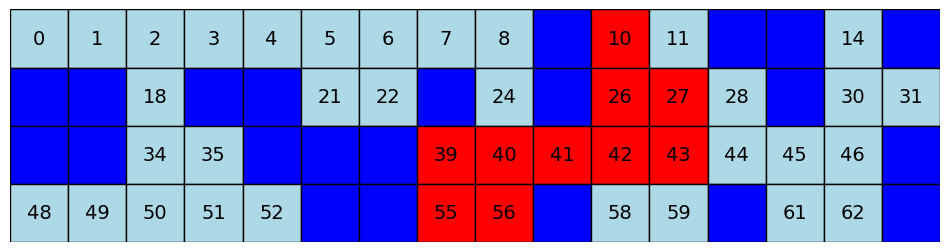

In [86]:
traverse_z(Z, A)
print(Z)
build_y(Z, Y, B)
print(Y)
print(list(map(vocabulary.__getitem__, Y)))

fig, ax = plt.subplots(figsize=(12, 9))
plot_maze(ax, maze, Z=Z)


### Interpreting the printed rows of the transition matrix \(A\)

For each time step \(t\), I look at the row \(A[Z_t]\):

- The row has 64 entries (one per state).
- Entry \(A[i,j]\) is the probability of moving from state \(i\) to state \(j\).
- Most entries are 0; non-zero values correspond to feasible neighbor moves
  (North, South, East, West).
- Probability of each neighbor is 1 / N-neighbors of current state

So printing `A[Z[t]]`
it just shows which row of \(A\) is used at each step of the trajectory.


## 2 Decoding and inference

### 2.1 Likelihood
1
Compute the likelihood of the obtained observation sequence $Y$.

In [87]:
def likelihood_calc(A, B, Y, pi):
    alpha = np.zeros((len(Y), len(B)))

    for i in range(len(B)):
        alpha[0][i] = pi[i // cols][i % cols] * B[i][Y[0]]

    for t in range(1, len(Y)):
        for j in range(len(B)):
            alpha[t][j] = B[j][Y[t]] * np.sum(alpha[t - 1] * A[:, j])
    return alpha, alpha[-1].sum()


alpha, likelihood = likelihood_calc(A, B, Y, start_prob)
likelihood

np.float64(8.409826423335537e-10)

### 2.1 Decoding 

Obtain the most probable state sequence, given the observation sequence $Y$.

In [88]:
def viterbi(A, B, Y, pi):
    v = np.zeros((len(Y), len(B)))
    back = np.zeros((len(Y), len(B)), dtype=int)
    for i in range(len(B)):
        v[0][i] = pi[i // cols][i % cols] * B[i][Y[0]]
        back[0][i] = -1

    for t in range(1, len(Y)):
        for j in range(len(B)):
            scores = v[t - 1] * A[:, j]
            best_prev = np.argmax(scores)
            v[t][j] = B[j][Y[t]] * scores[best_prev]
            back[t][j] = best_prev

    path = np.zeros(len(Y), dtype=int)
    path.fill(-1)
    j = -1
    for i in range(len(Y) - 1, -1, -1):
        if np.max(v[i]) == 0:
            continue
        path[i] = np.argmax(v[i])
        j = i
        break

    for t in range(j - 1, -1, -1):
        path[t] = back[t + 1][path[t + 1]]

    return v, path


v, path = viterbi(A, B, Y, start_prob)

print(path, 'most possible path')
print(Z, 'actual path')

[26 10 26 27 26 27 43 42 41 40 56 55 56 55 56 40 56 55 39 55] most possible path
[26 10 26 27 26 42 43 42 41 40 56 55 56 55 56 40 56 55 39 55] actual path


### 2.2 Filtering

Obtain the filtering distribution $P(z_t \mid y_{1:t})$ at each time step $t$.

In [89]:
def filtering(A, B, Y, pi):
    alpha, _ = likelihood_calc(A, B, Y, pi)
    return alpha / alpha.sum(axis=1, keepdims=True)


props_t = filtering(A, B, Y, start_prob)
props_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(20, 64))

### 2.3 Noisy observations

Repeat steps 2.1 and 2.2 in the presence of sensor error noise. In particular, consider that:
  * With probability $1-\epsilon$, the sensor provides the correct reading
  * With probability $\epsilon$, the sensor returns a wrong reading. 
  * The $\epsilon$ probability is equally split among all wrong readings.
  * Set $\epsilon=0.2$. Optionally, test also other values.

[26 10 26 27 26 42 43 42 41 40 56 55 56 55 56 40 56 55 39 55] actual path
[14  6 14 15 14 15 15 15 10 15  9 10  9 10  9 15  9 10  6 10] noisy sensory data
[14  6 14 15 14 15 15 15  3 15  9 10  9 10  9 15  9 10  6 10] actual sensory data
['(NSE)', '(SE)', '(NSE)', '(NSEW)', '(NSE)', '(NSEW)', '(NSEW)', '(NSEW)', '(NE)', '(NSEW)', '(NW)', '(NE)', '(NW)', '(NE)', '(NW)', '(NSEW)', '(NW)', '(NE)', '(SE)', '(NE)']


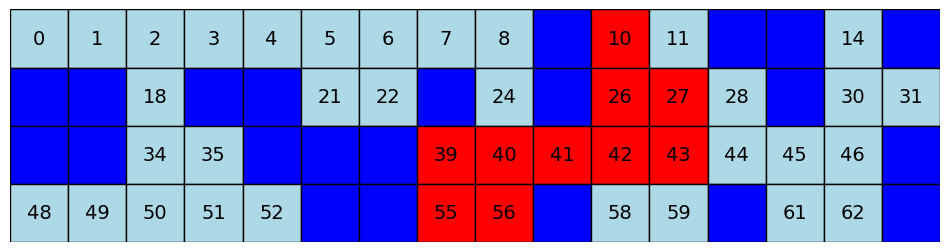

In [90]:
esp = 0.1

B_noisy = np.zeros_like(B)
for i in range(0, len(B)):
    B_noisy[i] = np.array([esp / (len(vocabulary)-1) if j != np.argmax(B[i]) else 1-esp for j in range(len(vocabulary))])
print(Z, 'actual path')
Y_noisy = np.zeros(t, dtype=int)
build_y(Z, Y_noisy, B_noisy)
print(Y_noisy, 'noisy sensory data')
print(Y, 'actual sensory data')
print(list(map(vocabulary.__getitem__, Y_noisy)))

fig, ax = plt.subplots(figsize=(12, 9))
plot_maze(ax, maze, Z=Z)

In [91]:
alpha, likelihood = likelihood_calc(A, B_noisy, Y_noisy, start_prob)
likelihood

np.float64(9.030396251593769e-13)

In [92]:
v, path = viterbi(A, B_noisy, Y_noisy, start_prob)

print(path, 'possible noisy path')
print(Z, 'actual path')

[26 10 26 27 26 27 43 42 41 40 56 55 56 55 56 40 56 55 39 55] possible noisy path
[26 10 26 27 26 42 43 42 41 40 56 55 56 55 56 40 56 55 39 55] actual path


In [93]:
props_t = filtering(A, B_noisy, Y_noisy, start_prob)
props_t

array([[2.25225225e-03, 2.25225225e-03, 2.25225225e-03, ...,
        2.25225225e-03, 2.25225225e-03, 0.00000000e+00],
       [7.52841978e-05, 2.00757861e-04, 2.25852594e-04, ...,
        1.25473663e-04, 1.25473663e-04, 0.00000000e+00],
       [1.50313714e-06, 2.25470571e-06, 5.35492607e-05, ...,
        1.81629071e-06, 3.53863535e-05, 0.00000000e+00],
       ...,
       [1.30754772e-21, 1.85411174e-25, 4.36651649e-17, ...,
        6.31009005e-06, 6.04311366e-18, 0.00000000e+00],
       [1.36849818e-27, 2.14877617e-19, 4.25454785e-27, ...,
        6.63159509e-14, 4.68044837e-08, 0.00000000e+00],
       [1.58007065e-21, 4.09828869e-29, 6.01866241e-19, ...,
        7.74413450e-08, 8.12740888e-16, 0.00000000e+00]], shape=(20, 64))

## 3 Analysis and discussion

Comment the techniques applied and the obtained results.

Look at ```report.pdf```